In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd

In [7]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [9]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Additional analysis using Inspect to for tables and columns

In [14]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [15]:
pd.DataFrame(inspector.get_columns('station'))

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


In [16]:
pd.DataFrame(inspector.get_columns('measurement'))

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0


# Exploratory Climate Analysis

In [17]:
engine.execute('SELECT max(date) FROM Measurement').fetchall()

[('2017-08-23',)]

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_start_date = dt.date(2017,8,23) - dt.timedelta(days=365-1)

# print(start and end dates)
query_end_date = dt.date(2017,8,23)
print(f"Start Date: {query_start_date}, End Date: {query_end_date}")

Start Date: 2016-08-24, End Date: 2017-08-23


In [19]:
# Perform a query to retrieve the data and precipitation scores

# Filtering the past 12 months
precipitation_scores = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_start_date).filter(measurement.date <= query_end_date).all()

In [20]:
# Pandas Database of measurement database cols Date (index) and precepitation scores.

precipitation_data = pd.DataFrame(precipitation_scores, columns=['Date', 'Precipitation'])
precipitation_data = precipitation_data.sort_values(by='Date')
precipitation_data = precipitation_data.set_index('Date')
precipitation_data = precipitation_data.dropna()
precipitation_data.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


<Figure size 720x504 with 0 Axes>

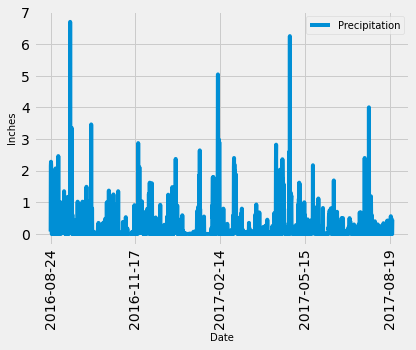

In [21]:
#  Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,7))
ax = precipitation_data.plot(rot=90);
ax.set_ylabel("Inches", fontsize = 10);
ax.set_xlabel("Date", fontsize = 10);
plt.legend(['Precipitation'], fontsize = 10)

In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_data.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(station.id).count()
print(f"There are {number_of_stations} stations")

There are 9 stations


In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [measurement.station, func.count(measurement.id)]
active_stations = session.query(*sel).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Station with the highest number of observations
sel = [measurement.station, func.count(measurement.id)]
active_stations = session.query(*sel).group_by(measurement.station).order_by(func.count(measurement.id).desc()).first()
print(f"Station with the hightest number of observations is {active_stations}.")

Station with the hightest number of observations is ('USC00519281', 2772).


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_station = 'USC00519281'
session.query(measurement.station, func.min(measurement.tobs),
              func.max(measurement.tobs),
              func.avg(measurement.tobs)).filter(measurement.station == max_station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

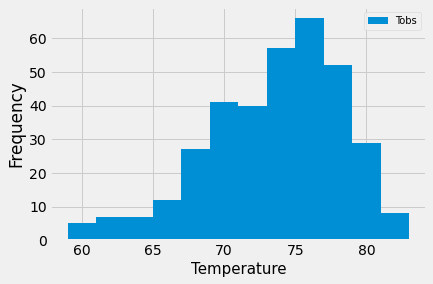

In [43]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram = session.query(measurement.tobs).\
    filter(measurement.station == max_station).\
    filter(measurement.date >= query_start_date).all()

histogram_chart = pd.DataFrame(histogram);
histogram_chart.plot.hist(bins=12);
plt.legend(['Tobs'], fontsize = 10);
plt.xlabel("Temperature", fontsize = 15);

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
